In [1]:
%matplotlib inline
import cv2
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
import os
import time
import csv
import scipy.sparse
import scipy.sparse.linalg
import scipy.signal
from sklearn.decomposition import FastICA
import dlr
from deepface import DeepFace
import pyrealsense2 as rs
from scipy import signal

In [2]:
file_time = '20230518-102456'

In [ ]:
#To get a relatively accurate estimation of hr, the length of the input video better sit between (30,60) secs
# To use a video file as input 
#cap = cv2.VideoCapture('ori.mp4')
font = cv2.FONT_HERSHEY_SIMPLEX
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
profile = pipeline.start(config)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

s=0
time_sequence = []
frame = 0
time_str = time.strftime("%Y%m%d-%H%M%S")
writer = cv2.VideoWriter('rPPG original {}.mp4'.format(time_str), -1, 19, (640, 480))
writer1 = cv2.VideoWriter('rPPG depth {}.mp4'.format(time_str), -1, 19, (640, 480))

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)


# To capture video from webcam. 
#cap = cv2.VideoCapture(0)
start_time = time.time()

while True:
    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames() 
    # Align the depth frame to color frame
    aligned_frames = align.process(frames)
    # Get aligned frames
    aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
    color_frame = aligned_frames.get_color_frame()
    
    if not aligned_depth_frame or not color_frame:
        print('no cohorent frames')
        continue
    frame_time = time.time()-start_time
    time_sequence.append(frame_time)
    frame = frame+1
    # Convert images to numpy arrays
    depth = np.asanyarray(aligned_depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    depth_image = cv2.convertScaleAbs(depth, alpha=255/2000)
        
    #save the video
    writer.write(color_image)
    writer1.write(depth_image)
    #writer1.write(depth_image)
    
    # Display
    cv2.imshow('img', color_image)
    cv2.setWindowProperty('img', cv2.WND_PROP_TOPMOST, 1)

    # Stop if escape key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        pipeline.stop()
        break
cv2. destroyAllWindows()
# Release the VideoCapture object
writer.release()
writer1.release()
run_time = time.time()-start_time
fps = frame/run_time

fname = "{}-{}.csv".format('rPPG original time sequence',time_str)
fpath = "{}".format(fname)
f = open(fpath, 'w', newline="")
csv.writer(f).writerows(map(lambda x: [x], time_sequence))
f.close()
print(('--- %s seconds ---' %(run_time)))
print(('--- %s fps ---' %(fps)))

In [3]:
#read the ECG data from the csv file; x:counter_axis time:time_axis y:ECG data
x = []
time = []
y = []

#example 20221028-163406-ecg.csv
with open('C://Users//gy299//{}-ecg.csv'.format(file_time),'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        y.append(int((row[0])))

length=len(y)
for i in range(1,length+1):
    x.append(i)
    time.append(0.002*i)

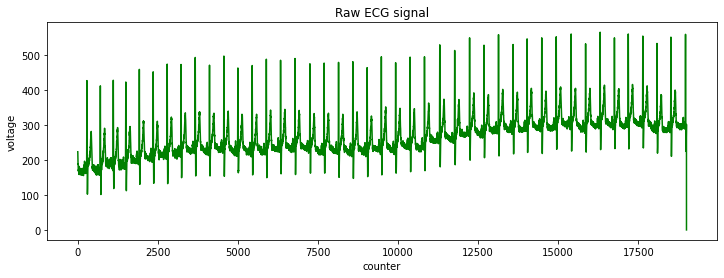

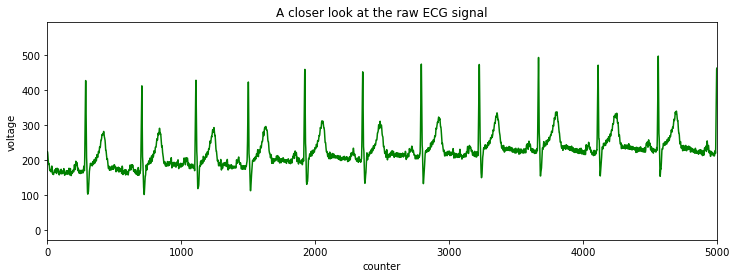

In [4]:
plt.figure(figsize=(12,4))
plt.plot(x,y, color = 'g')
#plt.ylim(600,1400)
plt.xlabel('counter')
plt.ylabel('voltage')
plt.title('Raw ECG signal')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(x,y, color = 'g')
plt.xlabel('counter')
plt.ylabel('voltage')
plt.xlim(0,5000)
#plt.ylim(600,1400)
plt.title('A closer look at the raw ECG signal')
plt.show()

In [5]:
data=np.array(y)
sample_rate=500
#detrend the signal to remove the baseline drift
detrended = signal.detrend(y)
#apply a [2,40]Hz bandpass filter
#filtered = hp.filter_signal(detrended, cutoff = 50, sample_rate = sample_rate, filtertype='notch')
#filtered = hp.filter_signal(detrended, cutoff = [0.67,3], sample_rate = sample_rate, filtertype= 'bandpass')
filtered = hp.filter_signal(detrended, cutoff = [2,40], sample_rate = sample_rate,order = 6, filtertype= 'bandpass')

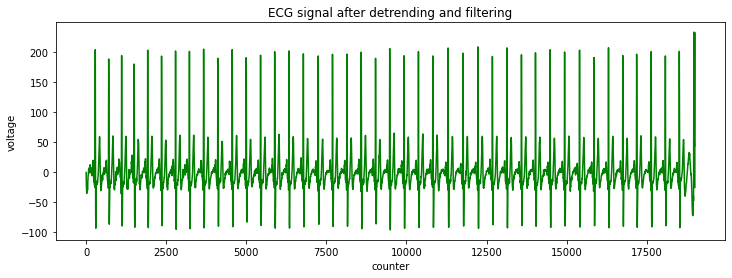

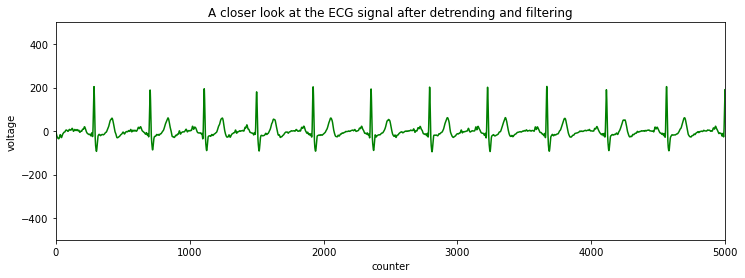

In [6]:
plt.figure(figsize=(12,4))
plt.plot(x,filtered, color = 'g')
plt.xlabel('counter')
plt.ylabel('voltage')
plt.title('ECG signal after detrending and filtering')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(x,filtered, color = 'g')
plt.xlabel('counter')
plt.ylabel('voltage')
plt.xlim(0,5000)
plt.ylim(-500,500)
plt.title('A closer look at the ECG signal after detrending and filtering')
plt.show()

In [7]:
#filtered[0:3000]=0

In [8]:
wd, m = hp.process(filtered, sample_rate, calc_freq=False,freq_method='fft')

bpm: 67.437380
ibi: 889.714286
sdnn: 30.850087
sdsd: 14.498066
rmssd: 24.230599
pnn20: 0.414634
pnn50: 0.048780
hr_mad: 13.000000
sd1: 17.088564
sd2: 39.758791
s: 2134.462960
sd1/sd2: 0.429806
breathingrate: 0.133333


<Figure size 864x288 with 0 Axes>

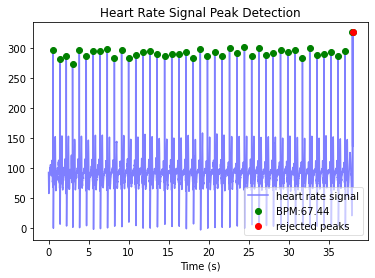

In [9]:
plt.figure(figsize=(12,4))
plot_object = hp.plotter(wd, m, show=False)
#plot_object.savefig('result.jpg') #saves the plot as JPEG image.
plot_object.show() #displays plot
#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [10]:
array=np.array(wd['peaklist'])/sample_rate

<Figure size 864x288 with 0 Axes>

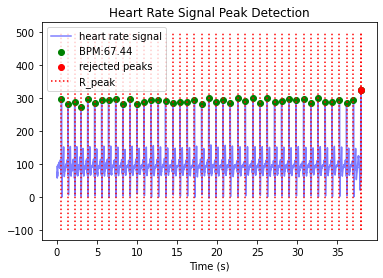

In [11]:
plt.figure(figsize=(12,4))
plot_object = hp.plotter(wd, m, show=False)
#plot_object.savefig('result.jpg') #saves the plot as JPEG image.
#plt.plot(time[:5000],filtered[:5000],color='b')
plt.vlines(x = array, ymin=-100,ymax=500,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
plt.legend()
plot_object.show() #displays plot

In [12]:
#To get a relatively accurate estimation of hr, the length of the input video better sit between (30,60) secs
x=0
y=0
w=h=1
s=0
previous_face=(x, y, w, h)
time_sequence = []
font = cv2.FONT_HERSHEY_SIMPLEX
time_difference = 0.795
#time_str = '20230509-135128'
#with open("{}-{}.csv".format('rPPG original time sequence',time_str),'r') as csvfile:
with open('rPPG original time sequence-{}.csv'.format(file_time),'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        time_sequence.append((float(row[0]))+time_difference)
average_b = []
average_g = []
average_r = []
frame = 0
writer = cv2.VideoWriter('rPPG ori.mp4', -1, 19, (640, 480))
writer1 = cv2.VideoWriter('rPPG output.mp4', -1, 19, (640, 480))
# To use a video file as input 
#cap = cv2.VideoCapture('rPPG original {}.mp4'.format(time_str))
#cap1 = cv2.VideoCapture('rPPG depth {}.mp4'.format(time_str))
cap = cv2.VideoCapture('rPPG original {}.mp4'.format(file_time))
cap1 = cv2.VideoCapture('rPPG depth {}.mp4'.format(file_time))
real_clipping_distance = 1000 #1 meter
clipping_distance = real_clipping_distance / (2000/256)


while True:
    # Read the frame
    ret, img = cap.read()
    ret1, depth_img = cap1.read()
    if ret and ret1:
        original_img = img.copy()
        frame = frame+1
        
        # Background removal(depth segmentation)
        zero_color = 0
        img = np.where((depth_img > clipping_distance) | (depth_img <= 0), zero_color, img)
                
        # Face detection
        faces=DeepFace.extract_faces(img,detector_backend='ssd',enforce_detection=False)
        # Draw the rectangle around each face
        for face in faces:
            (x,y,w,h)=(face['facial_area']['x'],face['facial_area']['y'],face['facial_area']['w'],face['facial_area']['h'])
            #check if the previous face location is almost the same to the current face location (5%)
            S=previous_face[2]*previous_face[3]
            S_difference=abs(x-previous_face[0])*abs(previous_face[3])+abs(previous_face[0]+previous_face[2]-x)*abs(y-previous_face[1])
            if S_difference/S <= 0.03:
                (x, y, w, h)=previous_face
                
            # Skin detection
            #converting from gbr to hsv color space
            img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            #skin color range for hsv color space 
            HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
            HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
            #converting from gbr to YCbCr color space
            img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            #skin color range for hsv color space 
            YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
            YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
            #merge skin detection (YCbCr and hsv)
            global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
            global_mask=cv2.medianBlur(global_mask,3)
            global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
            HSV_result = cv2.bitwise_not(HSV_mask)
            YCrCb_result = cv2.bitwise_not(YCrCb_mask)
            global_result = cv2.bitwise_not(global_mask)
            HSV_result = np.dstack((HSV_result,HSV_result,HSV_result))
            YCrCb_result = np.dstack((YCrCb_result,YCrCb_result,YCrCb_result))
            global_result = np.dstack((global_result,global_result,global_result))

            img = np.where(YCrCb_result == 255, zero_color, img)
            #Select ROI from the face area (80% height, 80% width)
            roi_face = img[y+h//10:y+9*h//10,x+w//10:x+9*w//10]
            cv2.rectangle(img, (x+w//10, y+h//10), (x+9*w//10, y+9*h//10), (0, 255, 0), 2)
            #roi_face = original_img[y:y+h,x:x+w]
            #cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            #roi_color = original_img[y:y+h, x:x+w]
            #Eye detection
            #eyes = eye_cascade.detectMultiScale(roi_gray,1.3,6)
            #for (ex,ey,ew,eh) in eyes:
                #cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        if len(faces)==0:
            average_b.append(0)
            average_g.append(0)
            average_r.append(0)
            cv2.putText(img, 'Error: no face detected', (0,20), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        elif len(faces)==1:    
            #Average colour intensity for each channel
            average_bgr = []
            for channel in range(0,3):
                average_color_row = np.average(roi_face[:,:,channel], axis=0)
                average_color = np.average(average_color_row, axis=0)
                average_bgr.append(average_color)
            #print('Average b,g,r value = ',average_bgr)
            cv2.putText(img, 'Average colour intensity in the blue channel:%s'%(round(average_bgr[0],3)), (0,20), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(img, 'Average colour intensity in the green channel:%s'%(round(average_bgr[1],3)), (0,40), font, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(img, 'Average colour intensity in the red channel:%s'%(round(average_bgr[2],3)), (0,60), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            average_b.append(average_bgr[0])
            average_g.append(average_bgr[1])
            average_r.append(average_bgr[2])
        else:
            average_b.append(0)
            average_g.append(0)
            average_r.append(0)
            cv2.putText(img, 'Error: {} faces detected'.format(len(faces)), (0,20), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

        #save the video
        if ret==True:
            writer.write(original_img)
            writer1.write(img)

        # Display
        cv2.imshow('img', img)
        cv2.setWindowProperty('img', cv2.WND_PROP_TOPMOST, 1)

        #store the previous face coordinate
        previous_face=(x, y, w, h)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cv2. destroyAllWindows()
# Release the VideoCapture object
cap.release()
writer.release()
writer1.release()

print(len(time_sequence))
print(len(average_b))

1107
1107


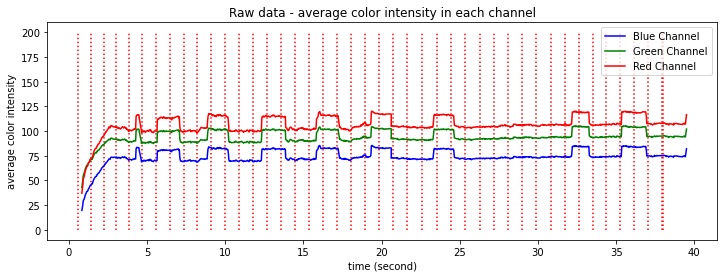

---1107 frames ---


In [13]:
#Average b,g,r plot per second
#x_data = range(1, frame+1)
# time_range = [5,35]
# index_range = [0, 0]
# for i in range(len(time_sequence)):
#     if time_sequence[i]>=time_range[0]:
#         index_range[0] = i
#         break
# for i in range(len(time_sequence)):
#     if time_sequence[i]<=time_range[1]:
#         index_range[1] = i

x_data = time_sequence
y_data_b = average_b
y_data_g = average_g
y_data_r = average_r
plt.figure(figsize=(12,4))
plt.plot(x_data, y_data_b, color='b')
plt.plot(x_data, y_data_g, color='g')
plt.plot(x_data, y_data_r, color='r')
plt.vlines(x = array, ymin=0,ymax=200,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
#plt.xlim((5,10))
#plt.xlabel('frame')
plt.xlabel('time (second)')
plt.ylabel('average color intensity')
plt.title('Raw data - average color intensity in each channel')
plt.legend(['Blue Channel', 'Green Channel', 'Red Channel'],loc='upper right')
plt.savefig('rgb')
#plt.xlim(15,25)
#plt.ylim(60,105)
plt.show()
print('---%s frames ---' %(frame))

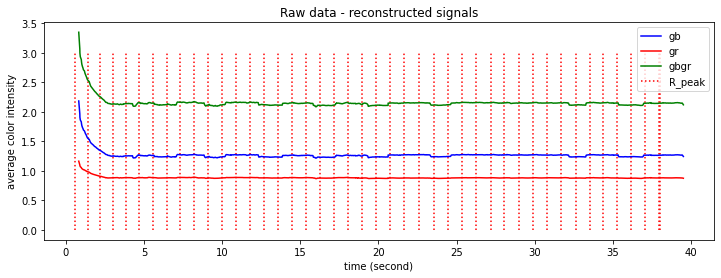

In [14]:
average_b=np.array(average_b)
average_g=np.array(average_g)
average_r=np.array(average_r)
gb = average_g/average_b
gr = average_g/average_r
plt.figure(figsize=(12,4))
plt.plot(x_data, gb, color='b',label ='gb')
plt.plot(x_data, gr, color='r', label = 'gr')
plt.plot(x_data, (gb+gr), color='g', label= 'gbgr')
plt.vlines(x = array, ymin=0,ymax=3,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
plt.legend()
plt.xlabel('time (second)')
plt.ylabel('average color intensity')
plt.title('Raw data - reconstructed signals')
#plt.xlim(15,25)
#plt.ylim(0.85,2.35)
plt.show()

In [15]:
print(np.std(average_b),np.std(average_g),np.std(average_r))
print(np.mean(average_b),np.mean(average_g),np.mean(average_r))

7.609936520877453 6.98251612226442 9.302264459411921
74.4857963924931 94.08489024035826 106.53989193237635


In [16]:
#Detrending raw b,g,r signal using a smoothness prior approach (regularisation parameter λ 10, 20, 50, 300=0.059, 0.041, 0.025, 0.011 * sampling frequency)
#λ = 20 #(for low sampling_frequency such as 10 fps)

def detrending(x):
    λ = 50
    K = x.shape[0]
    I = scipy.sparse.eye((K))
    D2 = scipy.sparse.spdiags((np.ones((K,1)) * [1,-2,1]).T ,[0,1,2], K-2, K)
    detrended = np.zeros(K)
    z =x[:K]
    term = scipy.sparse.csc_matrix(I + λ**2 * D2.T * D2)
    z_stationary = (I - scipy.sparse.linalg.inv(term)) * z
    detrended[:] = z_stationary
    return detrended

In [17]:
#detrended_b = detrending(average_b)
#detrended_g = detrending(average_g)
#detrended_r = detrending(average_r)
detrended_b = detrending(gb)
detrended_g = detrending(gb+gr)
detrended_r = detrending(gr)

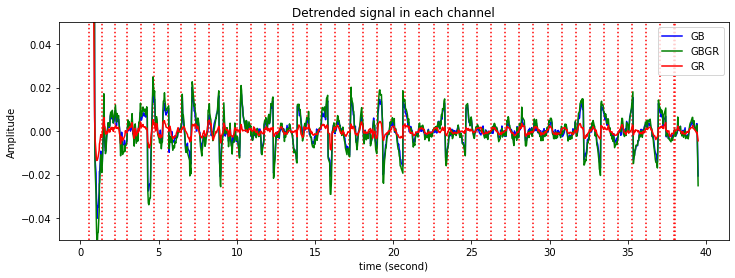

---1107 frames ---


In [18]:
#Detrended b,g,r signal plot per second
#x_data = range(1, frame+1)
x_data = time_sequence
y_data_b = detrended_b
y_data_g = detrended_g
y_data_r = detrended_r
plt.figure(figsize=(12,4))
plt.plot(x_data, y_data_b, color='b')
plt.plot(x_data, y_data_g, color='g')
plt.plot(x_data, y_data_r, color='r')
plt.vlines(x = array, ymin=-0.05,ymax=0.05,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
#plt.xlabel('frame')
#plt.xlim((,))
plt.xlabel('time (second)')
plt.ylabel('Amplitude')
plt.title('Detrended signal in each channel')
plt.legend(['GB', 'GBGR', 'GR'],loc='upper right')
#plt.xlim(15,25)
plt.ylim(-0.05,0.05)
plt.show()
print('---%s frames ---' %(frame))

In [19]:
#Normalisation of detrended signals (z-normalisation)
normalised_detrended_b=(detrended_b-np.mean(detrended_b))/np.std(detrended_b)
normalised_detrended_g=(detrended_g-np.mean(detrended_g))/np.std(detrended_g)
normalised_detrended_r=(detrended_r-np.mean(detrended_r))/np.std(detrended_r)

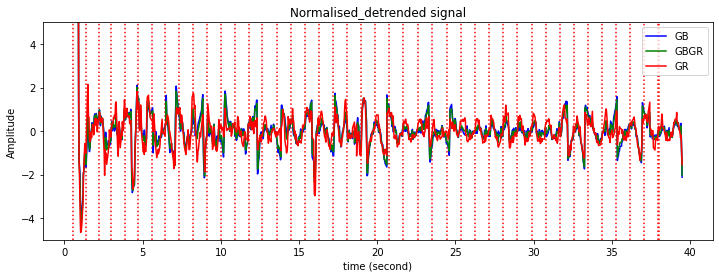

---1107 frames ---


In [20]:
#Normalised_detrended signal in b,g,r channels
#x_data = range(1, frame+1)
x_data = time_sequence
y_data_b = normalised_detrended_b
y_data_g = normalised_detrended_g
y_data_r = normalised_detrended_r
plt.figure(figsize=(12,4))
plt.plot(x_data, y_data_b, color='b')
plt.plot(x_data, y_data_g, color='g')
plt.plot(x_data, y_data_r, color='r')
plt.vlines(x = array, ymin=-5,ymax=5,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
#plt.xlabel('frame')
#plt.xlim((,))
plt.xlabel('time (second)')
plt.ylabel('Amplitude')
plt.title('Normalised_detrended signal')
plt.legend(['GB', 'GBGR', 'GR'],loc='upper right')
plt.savefig('pre-processing')
#plt.xlim(15,25)
plt.ylim(-5,5)
plt.show()
print('---%s frames ---' %(frame))

In [21]:
normalised_detrended_bgr= np.c_[normalised_detrended_b,normalised_detrended_g,normalised_detrended_r]
#ICA decomposition
ica = FastICA(n_components= 3)
ICA= ica.fit_transform(normalised_detrended_bgr)
#Reduce the redundant dimension
component1, component2, component3 = np.hsplit(ICA,3)
component1=np.squeeze(component1)
component2=np.squeeze(component2)
component3=np.squeeze(component3)

In [22]:
#Get the sampling rate
data=component2
#Data analysis using heartpy
#Switch time axis from sec to ms
timer=[x*1000 for x in time_sequence]
sample_rate = hp.get_samplerate_mstimer(timer)
print(sample_rate)

28.632466782759717


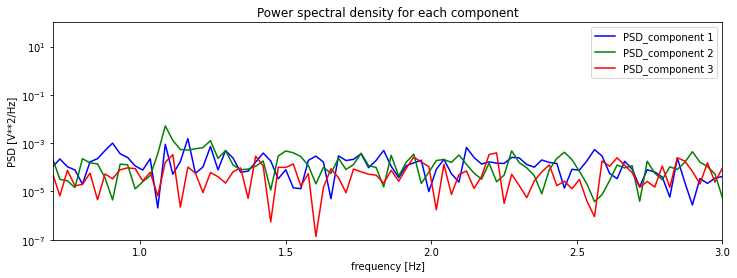

Component2 has the highest PSD peak within the desired bandpass frequency, which is 1.0863266530044338 Hz


In [23]:
#PSD analysis
f_component1, PSD_component1 = scipy.signal.periodogram(component1, fs=sample_rate)
f_component2, PSD_component2 = scipy.signal.periodogram(component2, fs=sample_rate)
f_component3, PSD_component3 = scipy.signal.periodogram(component3, fs=sample_rate)
plt.figure(figsize=(12,4))
plt.semilogy(f_component1, PSD_component1,color='b')
plt.semilogy(f_component2, PSD_component2, color='g')
plt.semilogy(f_component3, PSD_component3, color='r')
plt.ylim([1e-7, 1e2])
plt.xlim([0.7,3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power spectral density for each component')
plt.legend(['PSD_component 1', 'PSD_component 2', 'PSD_component 3'],loc='upper right')
plt.savefig('PSD')
plt.show()

#Select the component which has the highest PSD peak within the desired bandpass frequency [0.7, 3]
f_component = [0 ,0 ,0 ]
PSD_component = [0 ,0 ,0 ]
i_1=[]
i_2=[]
i_3=[]
highest_peak_1=highest_peak_2=highest_peak_3=-1e10
for index in range(len(f_component1)):
    while f_component1[index]>=0.7 and f_component1[index]<=3:
        i_1.append(index)
        break
for index in range(len(f_component2)):
    while f_component2[index]>=0.7 and f_component2[index]<=3:
        i_2.append(index)
        break
for index in range(len(f_component3)):
    while f_component3[index]>=0.7 and f_component3[index]<=3:
        i_3.append(index)
        break
        
for i in range(i_1[0],len(i_1)+1):
    if PSD_component1[i]>highest_peak_1:
        highest_peak_1=PSD_component1[i]
        f_component[0]=i
for i in range(i_2[0],len(i_2)+1):
    if PSD_component2[i]>highest_peak_2:
        highest_peak_2=PSD_component2[i]
        f_component[1]=i
for i in range(i_3[0],len(i_3)+1):
    if PSD_component3[i]>highest_peak_3:
        highest_peak_3=PSD_component3[i]
        f_component[2]=i

l= (highest_peak_1,highest_peak_2,highest_peak_3)
component=(component1,component2,component3)
#Index represents the index of the component which has the highest PSD peak
index= l.index(max(l))
print('Component{} has the highest PSD peak within the desired bandpass frequency, which is {} Hz'
      .format(index+1, f_component1[f_component[index]]))

In [24]:
data=component[index]
sample_rate = hp.get_samplerate_mstimer(timer)
print(sample_rate)

28.632466782759717


In [25]:
#Define the moving average filter and the bandpass filter
def movingAverageFilter(data, numPoints, doKeepSameLength=False):
    if(len(data) < 5):
        return data
    result = []
    
    isMid = numPoints % 2

        
    buffer = int(numPoints/2)
#     print(buffer)
#     print(len(data)-buffer)
    for i in range(buffer, len(data) - buffer + int(not isMid)):
#         print(i)
#         print(buffer)
#         print(i-buffer)
#         print(int(i+buffer+isMid))
#         print(data[i-buffer: int(i+buffer+isMid)])
        result.append(sum(data[i-buffer: int(i+buffer+isMid)])/numPoints)
        # print(data[i-buffer: i+buffer+isMid])

    return result


In [26]:
#Apply a five point moving average filter and a bandpass filter(128 points hamming window, [0,7,3]Hz)
averaged = movingAverageFilter(component[index], 5)
#bp=bandpassFilter(averaged, fs=sample_rate, cutOff=[0.7, 3])
bp=hp.filter_signal(  averaged, cutoff = [0.7, 3], sample_rate = sample_rate ,order = 6, filtertype= 'bandpass')

In [27]:
data=bp

In [28]:
#Process the data using heartpy
wd, m = hp.process(data, sample_rate, calc_freq=False,freq_method='fft')

bpm: 67.813737
ibi: 884.776486
sdnn: 95.054865
sdsd: 84.898804
rmssd: 134.854926
pnn20: 0.909091
pnn50: 0.681818
hr_mad: 69.850775
sd1: 95.330400
sd2: 74.832556
s: 22411.548695
sd1/sd2: 1.273916
breathingrate: 0.251298


<Figure size 864x288 with 0 Axes>

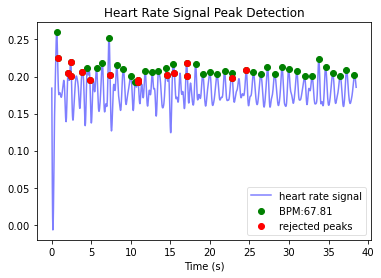

In [29]:
#call plotter
plt.figure(figsize=(12,4))
plot_object = hp.plotter(wd, m, show=False)
plot_object.savefig('result.jpg') #saves the plot as JPEG image.
plot_object.show() #displays plot

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

0.03633789030511585
SQI:0.75
Pulse Number: 42
The average IBI is 893.58 ms
HR: 69.48 bpm



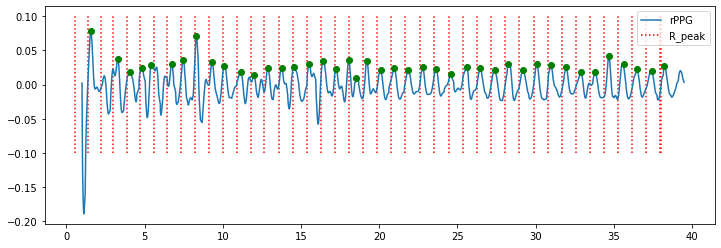

In [30]:
#find peaks function (prominence-distance-based method)
from scipy.signal import find_peaks
import statistics
IBI_list=[]
HR_list=[]
data=bp
#data=scipy.signal.savgol_filter(data, window_length=667, polyorder=2, mode="mirror")
#data=scipy.signal.detrend(data,type='linear')
peaks, properties = find_peaks(data, distance=(sample_rate/3), prominence=(0.001,None),width=None, height=None)
all_peaks = len(peaks)
#default prominence 0.025/abs(np.mean(data))
print(abs(np.mean(data))*55)
peaks, properties = find_peaks(data, distance=round(sample_rate/3), prominence=(0.025,None),width=None, height=None)
true_peaks = len(peaks)
print('SQI:{}'.format(true_peaks/all_peaks))

for i in range(1, len(peaks)):
    IBI_list.append((peaks[i]-peaks[i-1])/sample_rate)

HR_list=[60/x for x in IBI_list]
print('Pulse Number: {}'.format(len(peaks)))
print('The average IBI is {} ms'.format(round(statistics.mean(IBI_list)*1000,2)))
print('HR: {} bpm'.format(round(statistics.mean(HR_list),2)))
print()

plt.figure(figsize=(12,4))
plt.plot(time_sequence[4:],data,label='rPPG')
peak_index = [time_sequence[+4:][x] for x in peaks]
plt.plot(peak_index, data[peaks], "o",color='g')
plt.vlines(x = array, ymin=-0.1,ymax=0.1,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
plt.legend()
plt.show()

In [35]:
new_array =[]
new_peak_index = []
IBI_list_ECG = []
IBI_list_rPPG = []
time_range =[9.7,36.7]
for index in array:
    if index>time_range[0] and index<time_range[1]:
        new_array.append(index)
for index in peak_index:
    if index>time_range[0] and index<time_range[1]:
        new_peak_index.append(index)
for i in range(1, len(new_array)):
    IBI_list_ECG.append((new_array[i]-new_array[i-1]))
for i in range(1, len(new_peak_index)):
    IBI_list_rPPG.append((new_peak_index[i]-new_peak_index[i-1]))

HR_ECG = [60/x for x in IBI_list_ECG]
HR_rPPG = [60/x for x in IBI_list_rPPG]

print(len(IBI_list_rPPG))
print(len(IBI_list_ECG))
#print(IBI_list_rPPG)
#print(IBI_list_ECG)
print('ECG: {} bpm'.format(np.mean(HR_ECG)))
print('rPPG: {} bpm'.format(np.mean(HR_rPPG)))

30
29
ECG: 66.53112558607012 bpm
rPPG: 69.53697372251254 bpm


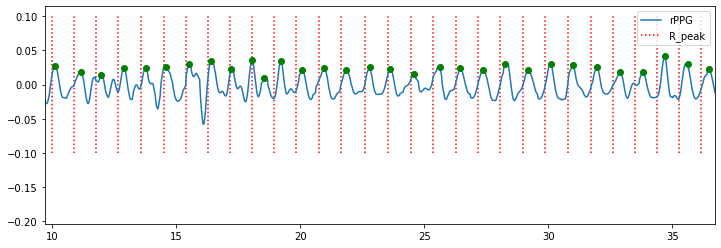

In [36]:
plt.figure(figsize=(12,4))
plt.plot(time_sequence[4:],data,label='rPPG')
peak_index = [time_sequence[4:][x] for x in peaks]
plt.plot(peak_index, data[peaks], "o",color='g')
plt.vlines(x = array, ymin=-0.1,ymax=0.1,
           colors = 'r',linestyles='dotted',
           label = 'R_peak')
plt.xlim(time_range[0],time_range[1])
plt.legend()
plt.show()

In [ ]:
if len(HR_ECG)==len(HR_rPPG):
    print('synchronised')
    plt.figure(figsize=(12,4))
    plt.plot(HR_ECG,color='g',label='HR_ECG')
    plt.plot(HR_rPPG,color='b',label='HR_radar')
    plt.ylabel('bpm')
    plt.xlabel('nth HR estimation')
    plt.legend()
    plt.title('Comparison between the HR estimations from ECG and Radar')
    plt.show()

    MAE=0
    AE=0
    for i in range(len(HR_ECG)):
        #print(abs(HR_ECG[i]-HR_radar[i]))
        MAE+=abs(HR_ECG[i]-HR_rPPG[i])
        AE+=(abs(HR_ECG[i]-HR_rPPG[i])/HR_ECG[i])*100
    
    MAE = MAE/len(HR_ECG)
    AE = AE/len(HR_ECG)
    print('The Mean Absolute Error is: {} bpm\nThe Average Error is: {} %'.format(MAE,AE))
else:
    print('desynchronised!')

In [ ]:
import statsmodels.api as sm
ECG=[]
rPPG=[]
print(type(ECG))
print(type(HR_ECG))

In [ ]:
ECG=ECG+HR_ECG
rPPG=rPPG+HR_rPPG

In [ ]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(np.array(ECG), np.array(rPPG), ax = ax)
plt.xlabel('Mean of HR_ECG and HR_rPPG')
plt.ylabel('Mean difference (bmp)')
plt.title('bland-altman plot')
plt.show()

In [ ]:
import pandas as panda
import numpy as np
import matplotlib.pyplot as plot
from numpy import linspace
from scipy.stats.kde import gaussian_kde

In [ ]:
IBI_ECG=[(60/x)*1000 for x in ECG]
IBI_rPPG=[(60/x)*1000 for x in rPPG]

In [ ]:
plot.figure(figsize=(12,5))
plot.hist((IBI_ECG, IBI_rPPG),bins=30, histtype='bar', rwidth=0.85, label=('IBI_ECG','IBI_rPPG'),color=('g','b'),density=True)

mn, mx = plot.xlim()
plot.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_ECG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_ECG",color='g')

kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_rPPG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_rPPG",color='b')

plot.xlabel('interbeat interval (IBI) [ms]')
plot.ylabel('Probability density [%]')
plot.title('Histogram of IBI distribution of ECG and rPPG')
plot.legend()
plot.show() 

plot.figure(figsize=(12,5))
plot.hist((IBI_ECG, IBI_rPPG),bins=20, histtype='bar', rwidth=0.85, label=('IBI_ECG','IBI_rPPG'),color=('g','b'), density=True)
mn, mx = plot.xlim()
plot.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_ECG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_ECG",color='g')

kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_rPPG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_rPPG",color='b')
plot.xlabel('interbeat interval (IBI) [ms]')
plot.ylabel('Probability density [%]')
plot.title('Histogram of IBI distribution of ECG and rPPG')
plot.legend()
plot.show() 


plot.figure(figsize=(12,5))
plot.hist((IBI_ECG, IBI_rPPG),bins=10, histtype='bar', rwidth=0.85, label=('IBI_ECG','IBI_rPPG'),color=('g','b'), density=True)
mn, mx = plot.xlim()
plot.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_ECG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_ECG",color='g')

kde_xs = np.linspace(mn, mx, 500)
kde = gaussian_kde(IBI_rPPG)
plot.plot(kde_xs, kde.pdf(kde_xs), label="PDF_rPPG",color='b')
plot.xlabel('interbeat interval (IBI) [ms]')
plot.ylabel('Probability density [%]')
plot.title('Histogram of IBI distribution of ECG and rPPG')
plot.legend()
plot.show() 